# Mapping Climatic and Seismic Data from the Stehekin Debris Flows

## Data Types:
- Seismic, request from IRIS
- Stream gauge data, request from USGS
- Precipitation data, request from NOAA

## Dependencies:

In [138]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

## Initialize IRIS
- This API is programmatic, we can pull directly from the code
- We pick the UW PNSN network's DREAM station from Stehekin in the North Cascades, nearby the Stehekin debris flows
- We select data from Dec. 13, the day that the debris flows began
- See PNSN page for the station here: https://pnsn.org/station/dream

In [139]:
# Initialize IRIS client
client = Client("IRIS")

# Define time range - a few days before to a few days after the debris flows
starttime = UTCDateTime("2025-12-10T00:00:00")
endtime = UTCDateTime("2025-12-13T00:00:00")

# Pull data from Stehekin station
network = 'UW'
station = 'DREAM'

try:
    st = client.get_waveforms(network, station, "*", "*", starttime, endtime)
    print(f"Successfully retrieved data for {network}.{station}")
except Exception as e:
    print(f"Error retrieving data for {network}.{station}: {e}")

Successfully retrieved data for UW.DREAM


## Data Processing
We pick the three-components of the seismogram and then plot:

In [142]:
# Merge traces with the same channel codes
st = st.merge(method=1, fill_value=0)
# Select specific channels using wildcards or multiple select calls
st_filtered = st.copy()
st = st_filtered.select(channel="ENZ") + st_filtered.select(channel="ENN") + st_filtered.select(channel="ENE")

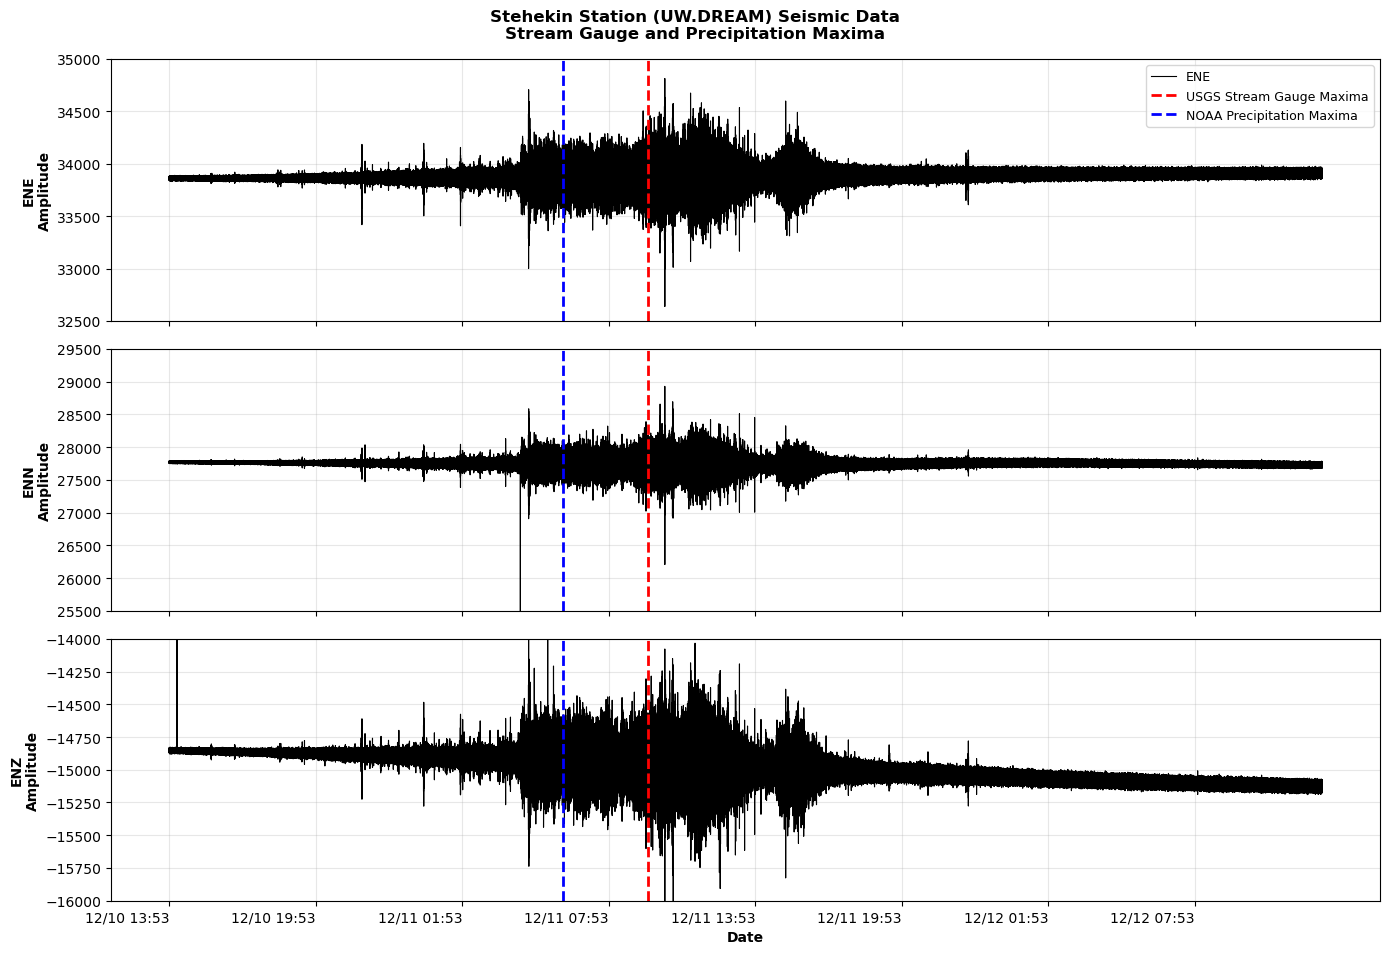

: 

In [ ]:
# Plot the components
num_traces = len(st)
fig, axes = plt.subplots(num_traces, 1, figsize=(14, 10), sharex=True)
time_shift = 50000  # Shift start time by 50,000 seconds for better visualization
# Trim the data to focus on the event window
st_subset = st.trim(starttime + time_shift, starttime + 220000)

# Plot each component
for i, tr in enumerate(st_subset.sort(['channel'])):
    ax = axes[i]
    
    # Setup time axis
    time = tr.times()
    
    # Plot waveform
    ax.plot(time, tr.data, 'k', linewidth=0.8, label=tr.stats.channel)
    ax.set_ylabel(f"{tr.stats.channel}\nAmplitude", fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add red, vertical dashed line at USGS stream gauge maxima
    gauge_maxima = UTCDateTime("2025-12-11T09:30:00")
    gauge_seconds = gauge_maxima - starttime - time_shift
    ax.axvline(gauge_seconds, color='red', linestyle='--', linewidth=2, label='USGS Stream Gauge Maxima' if i == 0 else "")

    # Add blue, vertical dashed line at NOAA precipitation maxima
    precip_maxima = UTCDateTime("2025-12-11T06:00:00")
    precip_seconds = precip_maxima - starttime - time_shift
    ax.axvline(precip_seconds, color='blue', linestyle='--', linewidth=2, label='NOAA Precipitation Maxima' if i == 0 else "")

    if i == 0:
        ax.legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel('Date', fontweight='bold')

# Create datetime labels for x-ticks
tick_positions = np.arange(0, 220000 - time_shift + 1, 21600)  # Every 6 hours in seconds
tick_datetimes = [(starttime + time_shift + pos).datetime for pos in tick_positions]

axes[-1].set_xticks(tick_positions)
axes[-1].set_xticklabels([mdates.DateFormatter('%m/%d %H:%M')(mdates.date2num(dt)) for dt in tick_datetimes], ha='right')

axes[0].set_ylim(32500, 35000)
axes[1].set_ylim(25500, 29500)
axes[2].set_ylim(-16000, -14000)

# Title
title = (f"Stehekin Station ({network}.{station}) Seismic Data\n"
         f"Stream Gauge and Precipitation Maxima")


fig.suptitle(title, fontsize=12, fontweight='bold', y=0.95)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

print()